# Groudon Detector

### Project Overview

In this project, we will be detecting anomalies in real data from the Apollo missions and the Mars InSight Lander to identify seismic quakes within the noise using LSTM Autoencoders using Keras with tensorflow backend.

## Task 1: Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 16, 6 # set figsize for all images

np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.17.0


In [ ]:
!pip3 install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 28.2 MB/s eta 0:00:00


In [ ]:
!pip3 show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [ ]:
!pip3 install tensorflow==2.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 235.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

To get you started on the data, we present to you a training set containing the following:

1. A catalog of quakes identified in the data
2. Seismic data collected by the Apollo (one day segments) or InSight (one hour segments) missions in miniseed and CSV format.
3. Plots of the trace and spectrogram for each day a quake has been identified.

Using these tools, your task is to come up with an algorithm to identify these signals (using the catalog as a benchmark) and then
apply your algorithm to the seismic data in the "test" folder (Apollo 12, 15, and 16 for the Moon and other InSight events for Mars).

Each trace included in the test folder has a quake in it, there are no empty traces.

This main folder also has a Jupyter notebook that will help you get started on the data.

** IMPORTANT **
Please make sure that your output catalog has at least the following headers:
filename
time_abs(%Y-%m-%dT%H:%M:%S.%f) or time_rel(sec)

If not, your output catalog may not be scored!!


[Data Source](https://drive.google.com/drive/folders/1RcArkpfBtYDVa07kB2sFb5-xAd8qrGKr?usp=sharing)

## Task 2: Load and Inspect the training datasets' names in fileList.csv

In [ ]:
fileList = pd.read_csv("/content/drive/MyDrive/fileList.csv")
fileList.iloc[:, 0]

,filename
0,xa.s12.00.mhz.1971-01-28HR00_evid00023
1,xa.s12.00.mhz.1971-04-17HR00_evid00030
2,xa.s12.00.mhz.1972-03-12HR00_evid00052
3,xa.s12.00.mhz.1973-01-31HR00_evid00091
4,xa.s12.00.mhz.1973-03-01HR00_evid00093
5,xa.s12.00.mhz.1973-03-13HR00_evid00094
6,xa.s12.00.mhz.1973-07-20HR00_evid00117
7,xa.s12.00.mhz.1974-04-27HR00_evid00145
8,xa.s12.00.mhz.1974-07-11HR00_evid00152


The LSTM network takes the input in the form of subsequences of equal intervals of input shape (n_sample, n_timesteps, features). We will use the below custom function to create these sequences

In [ ]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Concatenate all training data into one dataframe.


In [ ]:
import os
from obspy import read

m_df = pd.DataFrame(columns=['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'velocity(m/s)'])

mseed_directory = '/content/drive/MyDrive/trainingData/lunar/'

fileList = pd.read_csv("/content/drive/MyDrive/fileList.csv")

for i in range(9):
    filename = fileList.iloc[i, 0]
    filepath = os.path.join(mseed_directory, filename + ".mseed")
    st = read(filepath)
    tr = st[0]


    times = tr.times('timestamp')
    data = tr.data


    temp_df = pd.DataFrame({
        'time_abs(%Y-%m-%dT%H:%M:%S.%f)': pd.to_datetime(times, unit='s'),
        'velocity(m/s)': data
    })

    m_df = pd.concat([m_df, temp_df], ignore_index=True)

m_df

,time_abs(%Y-%m-%dT%H:%M:%S.%f),velocity(m/s)
0,1971-01-28 00:00:00.233999997,-6.479758e-16
1,1971-01-28 00:00:00.384943396,-7.847621e-16
2,1971-01-28 00:00:00.535886787,-8.317466e-16
3,1971-01-28 00:00:00.686830185,-7.897640e-16
4,1971-01-28 00:00:00.837773584,-6.954441e-16
...,...,...
4921623,1974-07-12 00:00:01.868433952,-1.626056e-15
4921624,1974-07-12 00:00:02.019377351,-2.362259e-15
4921625,1974-07-12 00:00:02.170320749,-2.814854e-15
4921626,1974-07-12 00:00:02.321264148,-3.902705e-15


# Task 3: Build and train LSTM Autoencoder

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from obspy import read
import os


def trainModel():

  scalar = StandardScaler() # set up scalar

  m_df = pd.DataFrame(columns=['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'velocity(m/s)'])

  fileList = pd.read_csv("/content/drive/MyDrive/fileList.csv")

  mseed_directory = '/content/drive/MyDrive/trainingData/lunar/'


  for i in range(9):
    filename = fileList.iloc[i, 0]
    filepath = os.path.join(mseed_directory, filename + ".mseed")
    st = read(filepath)
    tr = st[0]


    times = tr.times('timestamp')
    data = tr.data


    temp_df = pd.DataFrame({
        'time_abs(%Y-%m-%dT%H:%M:%S.%f)': pd.to_datetime(times, unit='s'),
        'velocity(m/s)': data
    })

    m_df = pd.concat([m_df, temp_df], ignore_index=True) # concatenate all training data into one dataframe.

  scalar = scalar.fit(m_df[['velocity(m/s)']]) # fit the scaler model


  model = Sequential() # set up model

  counter = 0

  # convert to .mseed file reading code
  for i in range(9):
    fileList = pd.read_csv("/content/drive/MyDrive/fileList.csv")
    train_filename = fileList.iloc[i, 0]


    data_directory = '/content/drive/MyDrive/trainingData/lunar/'
    mseed_file = f'{data_directory}{train_filename}.mseed'
    st = read(mseed_file)

    tr = st[0]
    times = tr.times('timestamp')
    data = tr.data
    train = pd.DataFrame({
        'time_abs(%Y-%m-%dT%H:%M:%S.%f)': pd.to_datetime(times, unit='s').strftime('%Y-%m-%dT%H:%M:%S.%f'),
        'velocity(m/s)': data
    })


    train['velocity(m/s)'] = scalar.transform(train[['velocity(m/s)']]) # normalize the data with the trained scalar

    time_steps = 30

    X_train, y_train = create_sequences(train[['velocity(m/s)']], train['velocity(m/s)'], time_steps) # create input sequences



    # Build LSTM Autoencoder
    timesteps = X_train.shape[1]
    num_features = X_train.shape[2]

    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(RepeatVector(timesteps)) # Repeats the input n times.
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(num_features))) # apply a layer to every temporal slice of an input.

    model.compile(loss='mae',optimizer='adam')


    # Train the built LSTM Autoencoder
    early_stop = EarlyStopping(monitor='val_loss',patience=3,mode='min') # if the monitored metric does not change wrt to the mode applied for 3 epochs, stop training
    history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.1, callbacks=[early_stop], shuffle=False)

    model.save('/content/drive/MyDrive/model/seismic_detection_model_'+ str(counter) +'.h5') # save the model by every iteration


    # freeze the trained layer to make it non-trainable after each iteration
    counter += 1
    currentindex = counter  * 6

    for layer in model.layers[:currentindex]:
        layer.trainable = False

  model.save('/content/drive/MyDrive/model/seismic_detection_model.h5')
  model.summary()

  return history, scalar, X_train, y_train

In [ ]:
history, scalar, X_train, y_train = trainModel()

Epoch 1/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 343s 169ms/step - loss: 0.2592 - val_loss: 0.2365
Epoch 2/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 339s 168ms/step - loss: 0.2590 - val_loss: 0.2365
Epoch 3/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 339s 168ms/step - loss: 0.2590 - val_loss: 0.2365
Epoch 4/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 339s 168ms/step - loss: 0.2590 - val_loss: 0.2365


Epoch 1/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 526s 258ms/step - loss: 0.3696 - val_loss: 0.2215
Epoch 2/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 520s 258ms/step - loss: 0.3694 - val_loss: 0.2215
Epoch 3/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 520s 258ms/step - loss: 0.3694 - val_loss: 0.2214
Epoch 4/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 519s 258ms/step - loss: 0.3694 - val_loss: 0.2215
Epoch 5/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 519s 258ms/step - loss: 0.3694 - val_loss: 0.2214
Epoch 6/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 518s 258ms/step - loss: 0.3694 - val_loss: 0.2215


Epoch 1/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 705s 346ms/step - loss: 0.1596 - val_loss: 0.1584
Epoch 2/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 696s 346ms/step - loss: 0.1593 - val_loss: 0.1584
Epoch 3/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 696s 346ms/step - loss: 0.1593 - val_loss: 0.1584
Epoch 4/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 696s 346ms/step - loss: 0.1593 - val_loss: 0.1584
Epoch 5/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 697s 346ms/step - loss: 0.1593 - val_loss: 0.1584


Epoch 1/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 889s 436ms/step - loss: 0.1622 - val_loss: 0.0995
Epoch 2/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 878s 436ms/step - loss: 0.1619 - val_loss: 0.0995
Epoch 3/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 877s 436ms/step - loss: 0.1619 - val_loss: 0.0995
Epoch 4/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 877s 436ms/step - loss: 0.1619 - val_loss: 0.0995


Epoch 1/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1072s 526ms/step - loss: 0.1915 - val_loss: 0.0414
Epoch 2/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1056s 525ms/step - loss: 0.1912 - val_loss: 0.0407
Epoch 3/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1057s 525ms/step - loss: 0.1912 - val_loss: 0.0408
Epoch 4/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1057s 525ms/step - loss: 0.1912 - val_loss: 0.0408
Epoch 5/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1057s 525ms/step - loss: 0.1912 - val_loss: 0.0410


Epoch 1/100
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 758s 616ms/step - loss: 0.4041 - val_loss: 0.1501
Epoch 2/100
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 739s 614ms/step - loss: 0.4038 - val_loss: 0.1502
Epoch 3/100
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 740s 614ms/step - loss: 0.4038 - val_loss: 0.1501
Epoch 4/100
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 740s 614ms/step - loss: 0.4038 - val_loss: 0.1501


Epoch 1/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1440s 706ms/step - loss: 0.1103 - val_loss: 0.0618
Epoch 2/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1418s 705ms/step - loss: 0.1100 - val_loss: 0.0618
Epoch 3/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1419s 705ms/step - loss: 0.1100 - val_loss: 0.0618
Epoch 4/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1419s 705ms/step - loss: 0.1100 - val_loss: 0.0618
Epoch 5/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1418s 705ms/step - loss: 0.1100 - val_loss: 0.0618


Epoch 1/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1623s 797ms/step - loss: 0.2390 - val_loss: 0.2644
Epoch 2/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1599s 795ms/step - loss: 0.2389 - val_loss: 0.2644
Epoch 3/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1600s 795ms/step - loss: 0.2389 - val_loss: 0.2644
Epoch 4/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1600s 795ms/step - loss: 0.2389 - val_loss: 0.2644
Epoch 5/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1600s 795ms/step - loss: 0.2389 - val_loss: 0.2644
Epoch 6/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1600s 795ms/step - loss: 0.2389 - val_loss: 0.2644
Epoch 7/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1600s 795ms/step - loss: 0.2389 - val_loss: 0.2644
Epoch 8/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1600s 795ms/step - loss: 0.2389 - val_loss: 0.2644
Epoch 9/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1601s 795ms/step - loss: 0.2389 - val_loss: 0.2644
Epoch 10/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1601s 795ms/step - loss: 0.2389 - val_loss: 0.2644


Epoch 1/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1806s 887ms/step - loss: 0.3588 - val_loss: 0.2307
Epoch 2/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1781s 885ms/step - loss: 0.3586 - val_loss: 0.2307
Epoch 3/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1781s 885ms/step - loss: 0.3586 - val_loss: 0.2307
Epoch 4/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1781s 885ms/step - loss: 0.3586 - val_loss: 0.2307
Epoch 5/100
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 1781s 885ms/step - loss: 0.3586 - val_loss: 0.2307


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 1)               │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 1)               │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,181,005 (8.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,784,457 (6.81 MB)

 Optimizer params: 396,548 (1.51 MB)

## Task 4: Plot history metrics

In [ ]:
print(history.history)

{'loss': [0.2469319850206375, 0.24689410626888275, 0.2468869537115097, 0.24689416587352753, 0.24688415229320526], 'val_loss': [0.23073774576187134, 0.2307278960943222, 0.2307293862104416, 0.23072808980941772, 0.2307310551404953]}


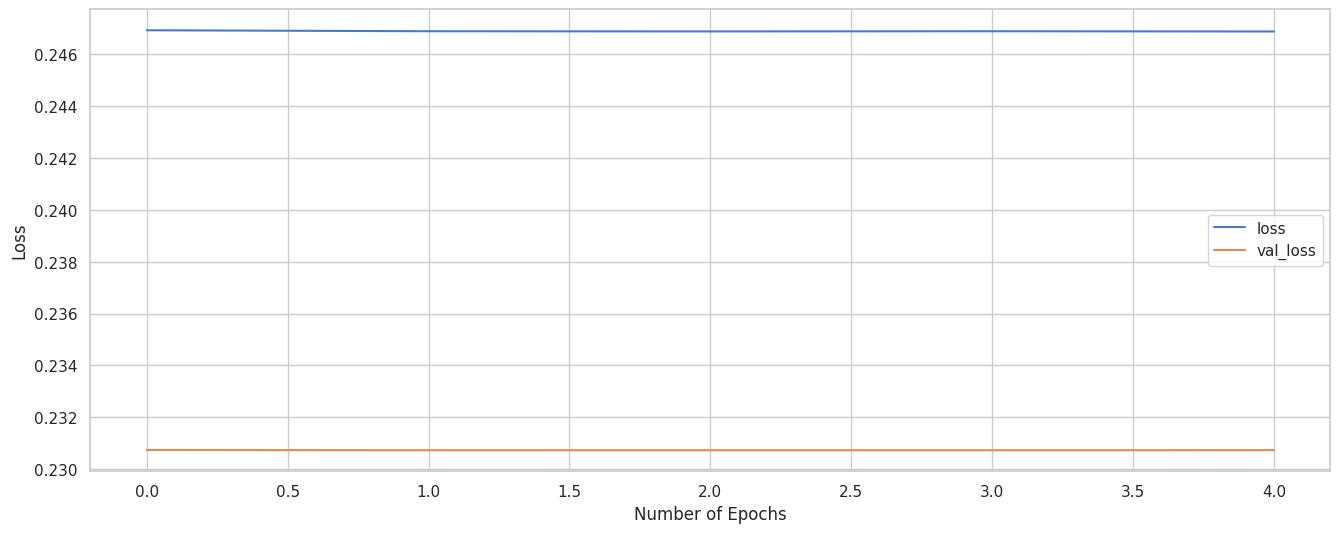

In [ ]:
err = pd.DataFrame(history.history)
err.plot()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss');

# Test 5: Load the saved model file

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model

from keras.src.legacy.saving import legacy_h5_format

model = legacy_h5_format.load_model_from_hdf5("/content/drive/MyDrive/model/seismic_detection_model.h5", custom_objects={'mae': 'mae'})


#history = tf.keras.models.load_model('/content/anomaly_model.h5')
print(model)
print(model.summary())

<Sequential name=sequential, built=True>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 1)               │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 1)               │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,784,459 (6.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,784,457 (6.81 MB)

 Optimizer params: 2 (12.00 B)

None


(Optional) If runtime is disconnected, you can run this following code cell to only train the scalar

In [ ]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

m_df = pd.DataFrame(columns=['time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'velocity(m/s)'])

fileList = pd.read_csv("/content/drive/MyDrive/fileList.csv")

mseed_directory = '/content/drive/MyDrive/trainingData/lunar/'


for i in range(9):
  filename = fileList.iloc[i, 0]
  filepath = os.path.join(mseed_directory, filename + ".mseed")
  st = read(filepath)
  tr = st[0]


  times = tr.times('timestamp')
  data = tr.data


  temp_df = pd.DataFrame({
      'time_abs(%Y-%m-%dT%H:%M:%S.%f)': pd.to_datetime(times, unit='s'),
      'velocity(m/s)': data
  })

  m_df = pd.concat([m_df, temp_df], ignore_index=True)

scalar = scalar.fit(m_df[['velocity(m/s)']]) # scaler model

# Task 6: Evaluate the model with running prediction

In [ ]:
# convert to .mseed file reading code
train_mae_loss_final = pd.DataFrame(columns=['Error'])

for i in range(9):
  fileList = pd.read_csv("/content/drive/MyDrive/fileList.csv")
  train_filename = fileList.iloc[i, 0]

  data_directory = '/content/drive/MyDrive/trainingData/lunar/'
  mseed_file = f'{data_directory}{train_filename}.mseed'
  st = read(mseed_file)

  tr = st[0]
  times = tr.times('timestamp')
  data = tr.data
  train = pd.DataFrame({
      'time_abs(%Y-%m-%dT%H:%M:%S.%f)': pd.to_datetime(times, unit='s').strftime('%Y-%m-%dT%H:%M:%S.%f'),
      'velocity(m/s)': data
  })


  train['velocity(m/s)'] = scalar.transform(train[['velocity(m/s)']])

  time_steps = 30

  X_train, y_train = create_sequences(train[['velocity(m/s)']], train['velocity(m/s)'], time_steps)

  # Calculating the mae for training data
  X_train_pred = model.predict(X_train)
  train_mae_loss_final = pd.concat([train_mae_loss_final, pd.DataFrame(np.mean(np.abs(X_train_pred - X_train),axis=1),columns=['Error'])])

17888/17888 ━━━━━━━━━━━━━━━━━━━━ 3228s 180ms/step
17888/17888 ━━━━━━━━━━━━━━━━━━━━ 3217s 180ms/step
17887/17887 ━━━━━━━━━━━━━━━━━━━━ 3220s 180ms/step
17887/17887 ━━━━━━━━━━━━━━━━━━━━ 3208s 179ms/step
17887/17887 ━━━━━━━━━━━━━━━━━━━━ 3220s 180ms/step
10699/10699 ━━━━━━━━━━━━━━━━━━━━ 1922s 180ms/step
17888/17888 ━━━━━━━━━━━━━━━━━━━━ 3220s 180ms/step
17887/17887 ━━━━━━━━━━━━━━━━━━━━ 3214s 180ms/step
17888/17888 ━━━━━━━━━━━━━━━━━━━━ 3212s 180ms/step


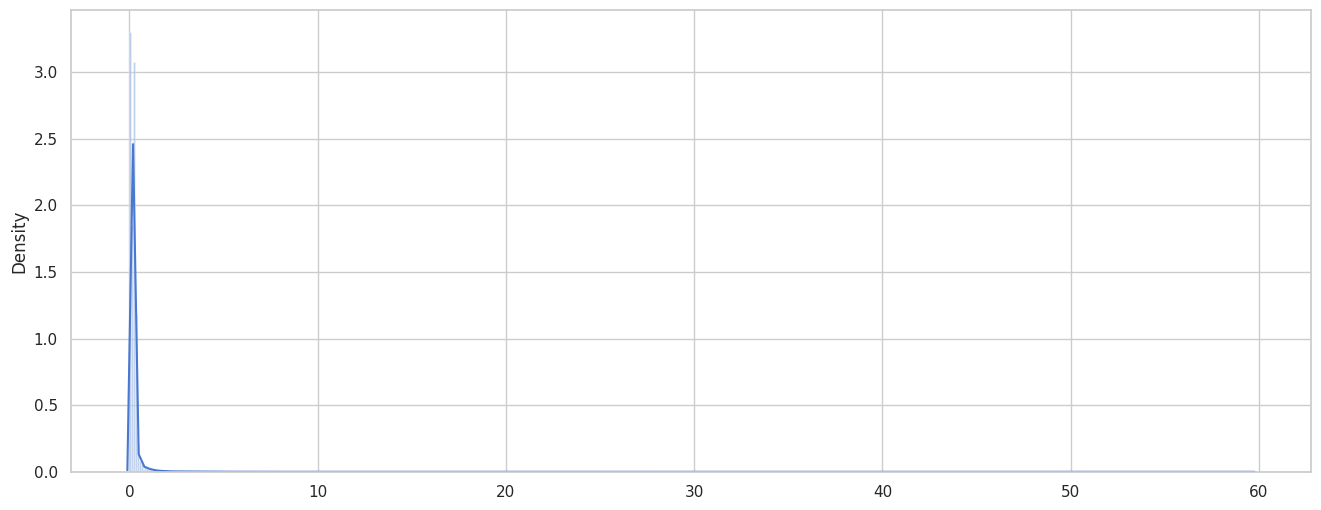

In [ ]:
sns.distplot(train_mae_loss_final,bins=600,kde=True); # Plot histogram of traning losses

In [ ]:
print(train_mae_loss_final)

           Error
0       0.005881
1       0.005881
2       0.005881
3       0.005881
4       0.005881
...          ...
572380  0.005883
572381  0.005883
572382  0.005883
572383  0.005883
572384  0.005883

[4921358 rows x 1 columns]


In [ ]:
filtered = train_mae_loss_final[(train_mae_loss_final['Error'] > 1.5) & (train_mae_loss_final['Error'] < 3)] # Use '&' for element-wise 'and' in pandas
filtered

,Error
55585,1.501386
55586,1.552707
55587,1.607422
55588,1.664270
55589,1.677463
...,...
223083,1.868466
223084,1.783789
223085,1.701999
223086,1.622558


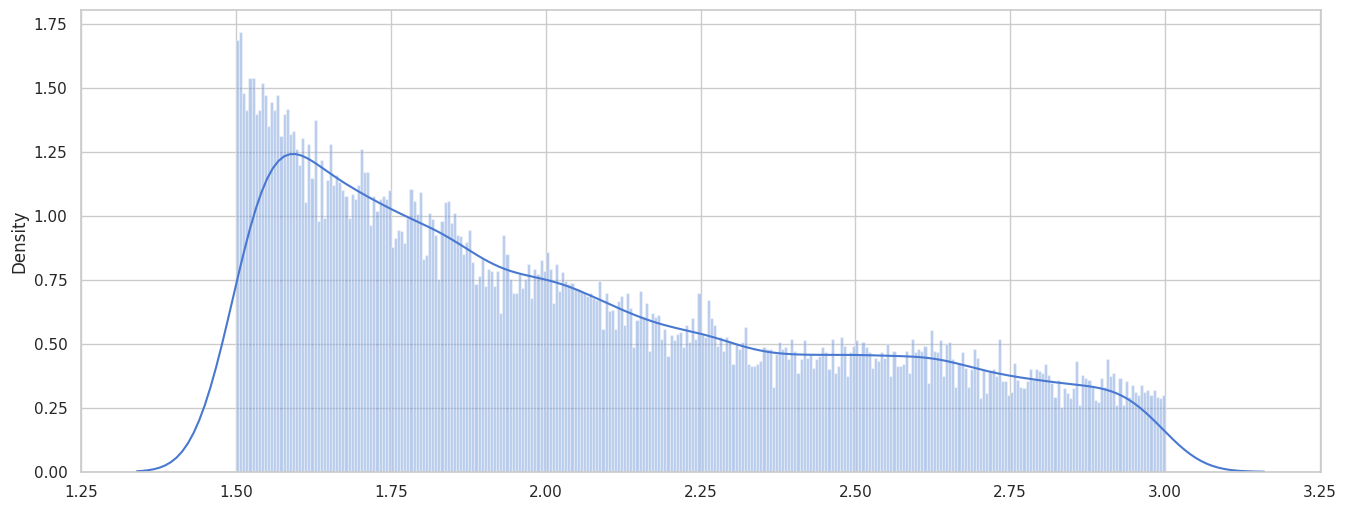

In [ ]:
sns.distplot(filtered,bins=300,kde=True); # Plot histogram of traning losses

Normalize the test data with the trained scalar

In [ ]:
# test dataset
test = pd.read_csv("/content/drive/MyDrive/dataFolder/testData/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.csv")

test['velocity(m/s)'] = scalar.transform(test[['velocity(m/s)']])

time_steps = 30

X_test, y_test = create_sequences(test[['velocity(m/s)']],test['velocity(m/s)'],time_steps)

X_test
y_test

array([0.00111089, 0.00110803, 0.00110536, ..., 0.00107038, 0.00105588,
       0.00102853])

We arbitrarily set up the threshold to 2.3 as we assume that the gradient of the training loss converges to 0 around 2.3

if we notice a error > threshold, we will say that it is an anamoly

In [ ]:
threshold = 2.3

In [ ]:
testDf = pd.DataFrame(train_mae_loss_final)
testDf.sort_values(by='Error', ascending=False)

,Error
193582,59.663825
193581,59.118382
193583,58.957016
193580,57.831837
193584,57.454251
...,...
110391,0.000071
110392,0.000069
83121,0.000067
83122,0.000063


In [ ]:
# Calculate mae for test data
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test),axis=1)

17888/17888 ━━━━━━━━━━━━━━━━━━━━ 3250s 182ms/step


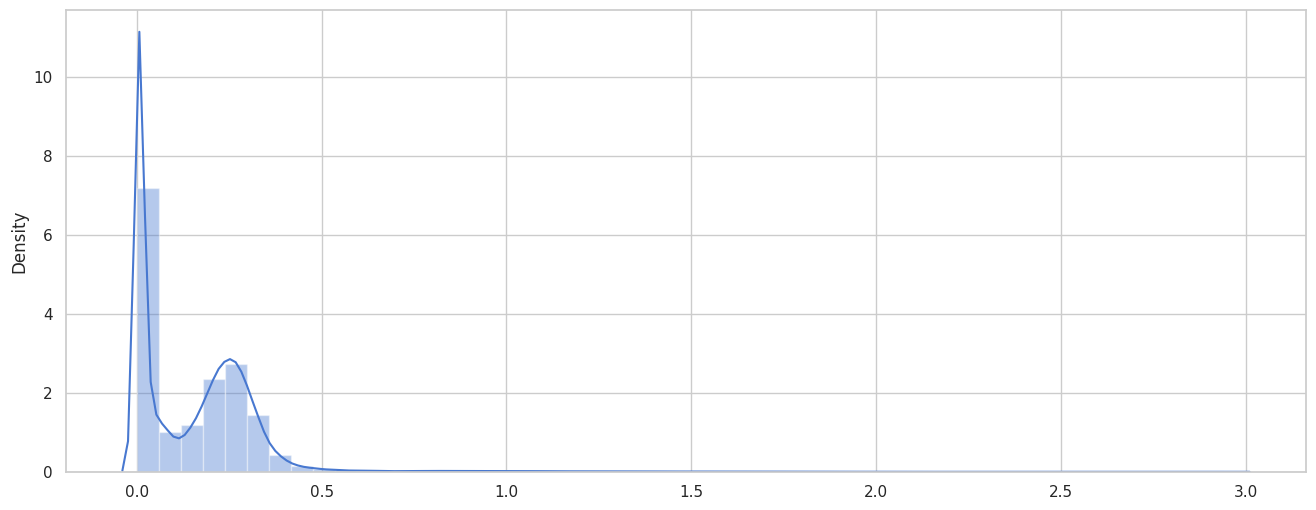

In [ ]:
sns.distplot(test_mae_loss, bins=50, kde=True); # Plot histogram of test losses

## Task 7: Detect Anomalies in the test data

In [ ]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['velocity(m/s)'] = test[time_steps:]['velocity(m/s)']

In [ ]:
test_score_df.head()

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s),loss,threshold,anomaly
30,1969-12-16T00:00:04.706302,4.528302,0.001111,0.005894,2.3,False
31,1969-12-16T00:00:04.857245,4.679245,0.001108,0.005894,2.3,False
32,1969-12-16T00:00:05.008189,4.830189,0.001105,0.005894,2.3,False
33,1969-12-16T00:00:05.159132,4.981132,0.001103,0.005894,2.3,False
34,1969-12-16T00:00:05.310075,5.132075,0.001100,0.005895,2.3,False


In [ ]:
test_score_df.tail()

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s),loss,threshold,anomaly
572418,1969-12-17T00:00:02.894981,86402.716981,0.001086,0.005902,2.3,False
572419,1969-12-17T00:00:03.045925,86402.867925,0.001076,0.005902,2.3,False
572420,1969-12-17T00:00:03.196868,86403.018868,0.001070,0.005902,2.3,False
572421,1969-12-17T00:00:03.347811,86403.169811,0.001056,0.005902,2.3,False
572422,1969-12-17T00:00:03.498755,86403.320755,0.001029,0.005901,2.3,False


Save the record of the detected anomalies as a CSV file.

In [ ]:
test_score_df.to_csv('/content/drive/MyDrive/model/output.csv', index = False)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:]['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],y=test_score_df['loss'],mode='lines',name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:]['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],y=test_score_df['threshold'],mode='lines',name='Threshold'))
fig.update_layout(xaxis_title='Time',yaxis_title='Loss',showlegend=True)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
anomalies = test_score_df[test_score_df['anomaly']==True]
anomalies

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s),loss,threshold,anomaly
500325,1969-12-16T20:58:40.932717,75520.754717,2.860820,2.301639,2.3,True
500326,1969-12-16T20:58:41.083660,75520.905660,2.859855,2.321399,2.3,True
500327,1969-12-16T20:58:41.234604,75521.056604,2.858890,2.339914,2.3,True
500328,1969-12-16T20:58:41.385547,75521.207547,2.857924,2.357183,2.3,True
500329,1969-12-16T20:58:41.536491,75521.358491,2.856959,2.373208,2.3,True
...,...,...,...,...,...,...
500616,1969-12-16T20:59:24.857245,75564.679245,2.469261,2.381471,2.3,True
500617,1969-12-16T20:59:25.008189,75564.830189,2.420762,2.381883,2.3,True
500618,1969-12-16T20:59:25.159132,75564.981132,1.641834,2.381978,2.3,True
500619,1969-12-16T20:59:25.310075,75565.132075,1.209188,2.357409,2.3,True


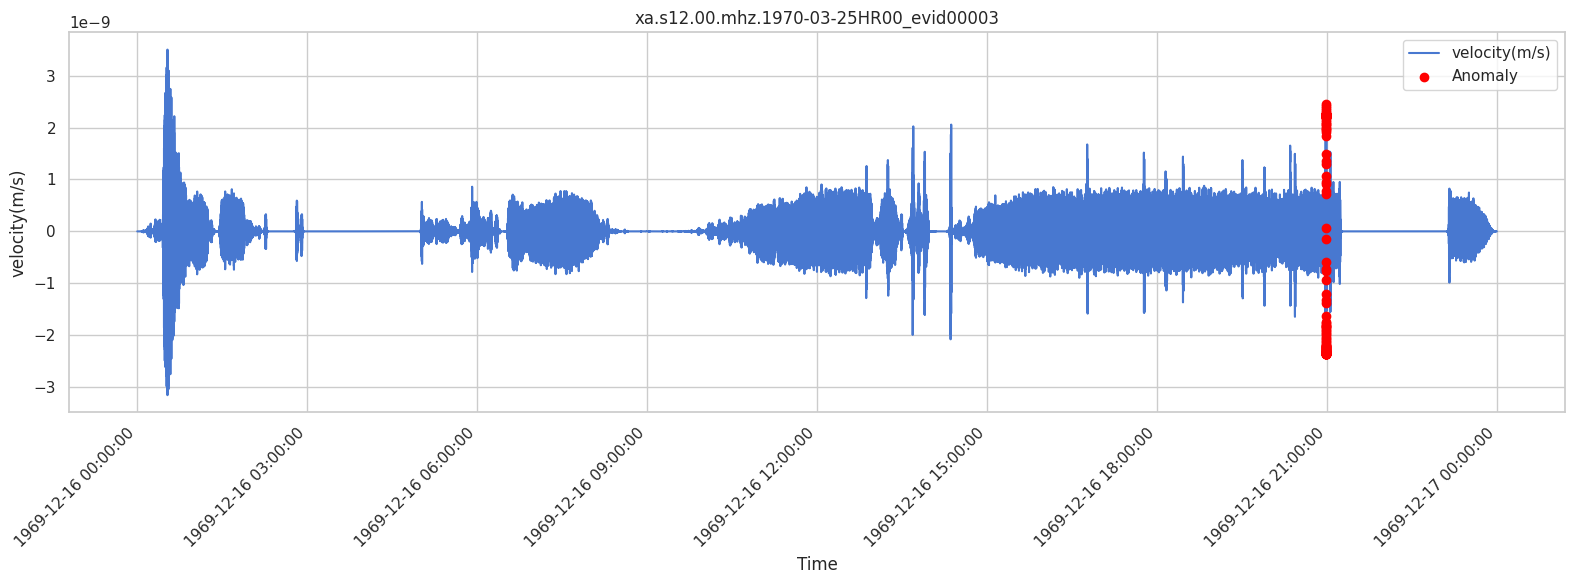

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convert x data to datetime objects
x1 = pd.to_datetime(test[time_steps:]['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], format='%Y-%m-%dT%H:%M:%S.%f')
x2 = pd.to_datetime(anomalies['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], format='%Y-%m-%dT%H:%M:%S.%f')

# Extract y data
y1 = scalar.inverse_transform(test[time_steps:][['velocity(m/s)']])
y2 = scalar.inverse_transform(anomalies[['velocity(m/s)']])

# Create figure and axis
fig, ax = plt.subplots()

# Plot the first trace as a line
ax.plot(x1, y1, label='velocity(m/s)', zorder=1)

# Plot the second trace as markers
ax.scatter(x2, y2, color='red', label='Anomaly', zorder=2)

# Format the x-axis for dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate date labels if necessary
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('velocity(m/s)')
ax.set_title('xa.s12.00.mhz.1970-03-25HR00_evid00003')

# Show legend
ax.legend()

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
import pandas as pd

def getAnomal(df, filename):
    """
    Detects anomalies in the provided DataFrame and records the corresponding
    absolute and relative times along with the associated filename. An anomaly
    is flagged when a buffer of 840 approximately a minute since earthquake typicllay does not last more than a minute
    to avoid duplicate detections. And more non-anomalous entries is found before a new anomaly is detected.

    Parameters:
    df (DataFrame): Input data with columns 'anomaly', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)',
                    and 'time_rel(sec)'.
    filename (str): The name of the file from which the data originated.

    Returns:
    list: A list of three lists containing filenames, absolute times, and relative times of anomalies.
    """
    abs_time = []
    time_rel = []
    files = []
    found = False
    buffer = 0
    for row in df.index:
        cur_row = df.loc[row]
        if(cur_row["anomaly"] == True and found == False and buffer >= 840):
            abs_time.append(cur_row["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
            time_rel.append(cur_row["time_rel(sec)"])
            files.append(filename)
            found = True
        elif(cur_row["anomaly"] == False and found == True):
            buffer = 0
            found = False
        else:
            buffer += 1
    return [files, abs_time, time_rel]

def getOutput(timestamps):
    """
    Converts a list of anomaly information into a Pandas DataFrame with columns
    for filenames, absolute times, and relative times.

    Parameters:
    timestamps (list): A list of three lists:
        - timestamps[0]: List of filenames.
        - timestamps[1]: List of absolute times in the format '%Y-%m-%dT%H:%M:%S.%f'.
        - timestamps[2]: List of relative times in seconds.

    Returns:
    DataFrame: A DataFrame containing the anomaly data with columns
               'filename', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)', and 'time_rel(sec)'.
    """
    data = {
        "filename" : timestamps[0],
        "time_abs(%Y-%m-%dT%H:%M:%S.%f)" : timestamps[1],
        "time_rel(sec)" : timestamps[2],
    }
    df = pd.DataFrame(data)
    return df

def saveToCSV(fileList, path, planet, savePath, fileTitle):
    """
    Processes a list of CSV files to detect anomalies, compiles the results into a single
    DataFrame, and saves the output to a new CSV file.

    Parameters:
    fileList (list): List of filenames (without extensions) to be processed.
    path (str): The directory path where the input CSV files are located.
    planet (str): The name of the planet or identifier used in the output filename.
    savePath (str): The directory where the output CSV file will be saved.

    Returns:
    None: The function saves the resulting DataFrame as a CSV file with the format
          '<savePath>/<planet>_catalog.csv'.
    """
    result = pd.DataFrame()
    for file in fileList:
        filepath = path + file + ".csv"
        df = pd.read_csv(filepath)
        timestamps = getAnomal(df, fileTitle)
        temp_result = getOutput(timestamps)
        result = result._append(temp_result, ignore_index=True)
    result.to_csv(f'{savePath}{planet}_catalog.csv', index = False)

fileList = ["output"]
fileTitle = "S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.csv"
path = "/content/drive/MyDrive/model/"
planet = "lunar"
savePath = "/content/drive/MyDrive/"
saveToCSV(fileList, path, planet, savePath, fileTitle)